# **Fruit Classification**

The aim of this project is to create a classifier that is able to correctly classify images of fruits and vegetables by their kind. The data used for this project is a taken from "Fruit Classfication" on Kaggle and consists of 22,495 images (16,854 train | 5,641 test). There are 33 classes with each corresponding to a unique fruit or vegetable. Each image is (100, 100, 3) which lends to length and width of 100 pixels and 3 channels corresponding to RGB colors.

We will use Convolutional Neural Networks (CNN) to process the fruit and vegetable images and classify them to their kinds. CNNs have been proven successfull by their wide ranging success in image classification and are tailored to this kind of problem.

**The end goal is the construction of a performant classifier so that we can load in images of fruits and vegetables an identify what kind they are.**

## Package Import and Data Loading

Importing the Python packages that will be needed to operate this project.

In [1]:
import os
import keras
import tensorflow

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
from google.colab import drive

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras import datasets, layers, models

Establishing a connection to my Google Drive and using linux commands to hit Kaggle's API to collect the dataset for this competition/project.

In [2]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (2).json


{'kaggle (2).json': b'{"username":"cadenzonefeld","key":"d0a0fadb8d1e4ba8c191b6e6e913f4b5"}'}

In [4]:
!ls -lha kaggle.json
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!pwd

-rw-r--r-- 1 root root 69 Oct 13 20:17 kaggle.json
/content


In [5]:
!chmod 600 ~/.kaggle/kaggle.json

In [6]:
!kaggle datasets list

ref                                                         title                                          size  lastUpdated          downloadCount  voteCount  usabilityRating  
----------------------------------------------------------  --------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
nelgiriyewithana/top-spotify-songs-2023                     Most Streamed Spotify Songs 2023               47KB  2023-08-26 11:04:57          30102        902  1.0              
iamsouravbanerjee/customer-shopping-trends-dataset          Customer Shopping Trends Dataset              146KB  2023-10-05 06:45:37           3673         92  1.0              
zedataweaver/global-salary-data                             Global Salary Data                              5KB  2023-10-03 00:55:24           1459         42  1.0              
nelgiriyewithana/credit-card-fraud-detection-dataset-2023   Credit Card Fraud Detection Dataset 2023      143M

In [7]:
!kaggle datasets download -d sshikamaru/fruit-recognition

fruit-recognition.zip: Skipping, found more recently modified local copy (use --force to force download)


In [8]:
!unzip fruit-recognition

Archive:  fruit-recognition.zip
replace sampleSubmission.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

Loading the train and test datasets which consist of different fruits and vegetables. Since the images are stored in different directories we will have to stitch them together into a single dataset.

In [9]:
os.listdir('train/train')

['Banana',
 'Grape Blue',
 'Tomato',
 'Mango',
 'Cherry',
 'Onion White',
 'Pineapple',
 'Pepper Red',
 'Apple Granny Smith',
 'Pepper Green',
 'Cucumber Ripe',
 'Plum',
 'Blueberry',
 'Peach',
 'Apple Braeburn',
 'Pomegranate',
 'Pear',
 'Clementine',
 'Orange',
 'Papaya',
 'Cantaloupe',
 'Kiwi',
 'Avocado',
 'Corn',
 'Potato Red',
 'Watermelon',
 'Limes',
 'Cactus fruit',
 'Strawberry',
 'Passion Fruit',
 'Apricot',
 'Raspberry',
 'Lemon']

Sample of the contents of one of the fruit/vegetable directories.

In [10]:
os.listdir('train/train/Lemon')[:10]

['Lemon_278.jpg',
 'Lemon_318.jpg',
 'Lemon_84.jpg',
 'Lemon_188.jpg',
 'Lemon_323.jpg',
 'Lemon_244.jpg',
 'Lemon_398.jpg',
 'Lemon_329.jpg',
 'Lemon_349.jpg',
 'Lemon_276.jpg']

Stitching the images together from each of the 33 directories corresponding to a fruit or vegetable into a single dataset with a "File" attribute for the path to the image and a "Class" attribute for the fruit or vegetable the image depicts.

In [11]:
train_dir = 'train/train'
target_classes = os.listdir(train_dir)

train = []
for tclass in target_classes:
  imgs = os.listdir(train_dir+'/'+tclass)
  imgs = [train_dir + '/' + tclass + '/' + img for img in imgs]
  df = pd.DataFrame({'File':imgs, 'Class':tclass})
  train.append(df)

train_df = pd.concat(train)

In [12]:
print("Shape of train dataset:", train_df.shape)
train_df.head()

Shape of train dataset: (16854, 2)


,File,Class
0,train/train/Banana/Banana_473.jpg,Banana
1,train/train/Banana/Banana_332.jpg,Banana
2,train/train/Banana/Banana_460.jpg,Banana
3,train/train/Banana/Banana_183.jpg,Banana
4,train/train/Banana/Banana_231.jpg,Banana


## Exploratory Data Analysis

Examining the distribution of fruit and vegetable classes.

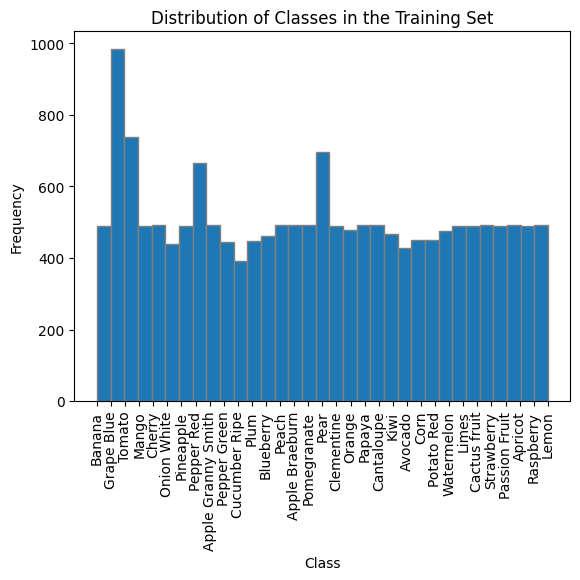

In [13]:
plt.hist(train_df['Class'], bins=33, edgecolor='grey')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.xticks(rotation=90)
plt.title('Distribution of Classes in the Training Set')
plt.show()

The distribution of fruits in the training set is evenly distributed for the most part with most fruits having 400-500 occurences. Pear, grapeblue, tomato, and red pepper are outliers compared to the rest as each has 650+ occurences in the data set.

In [14]:
train_df['Class'].value_counts()

Grape Blue            984
Tomato                738
Pear                  696
Pepper Red            666
Peach                 492
Apricot               492
Strawberry            492
Cantaloupe            492
Papaya                492
Pomegranate           492
Apple Braeburn        492
Lemon                 492
Apple Granny Smith    492
Cherry                492
Banana                490
Raspberry             490
Mango                 490
Clementine            490
Pineapple             490
Passion Fruit         490
Cactus fruit          490
Limes                 490
Orange                479
Watermelon            475
Kiwi                  466
Blueberry             462
Potato Red            450
Corn                  450
Plum                  447
Pepper Green          444
Onion White           438
Avocado               427
Cucumber Ripe         392
Name: Class, dtype: int64

Sample of what the contents of the test dataset look like.

In [15]:
os.listdir('test/test')[:15]

['3321.jpg',
 '4759.jpg',
 '1441.jpg',
 '2430.jpg',
 '5107.jpg',
 '1634.jpg',
 '3267.jpg',
 '4217.jpg',
 '5531.jpg',
 '2189.jpg',
 '0431.jpg',
 '3335.jpg',
 '5396.jpg',
 '1475.jpg',
 '4522.jpg']

In [16]:
test_dir = 'test/test'

imgs = os.listdir(test_dir)
imgs = [test_dir + "/" + img for img in imgs]
test_df = pd.DataFrame({'File':imgs, 'Class':None})

In [17]:
print("Shape of test dataset:", test_df.shape)
test_df.head()

Shape of test dataset: (5641, 2)


,File,Class
0,test/test/3321.jpg,None
1,test/test/4759.jpg,None
2,test/test/1441.jpg,None
3,test/test/2430.jpg,None
4,test/test/5107.jpg,None


Based on the size of the train and test datasets we can conclude that the original train test split allocated 75% of data to training and 25% to testing.

In [18]:
print("Proportion of train data from train-test split:", np.round(train_df.shape[0]/(train_df.shape[0]+test_df.shape[0]), 2))
print("Proportion of test data from train-test split:", np.round(test_df.shape[0]/(train_df.shape[0]+test_df.shape[0]), 2))

Proportion of train data from train-test split: 0.75
Proportion of test data from train-test split: 0.25


Examples of what an image for each of the 33 different kinds of fruits and vegetables look like.

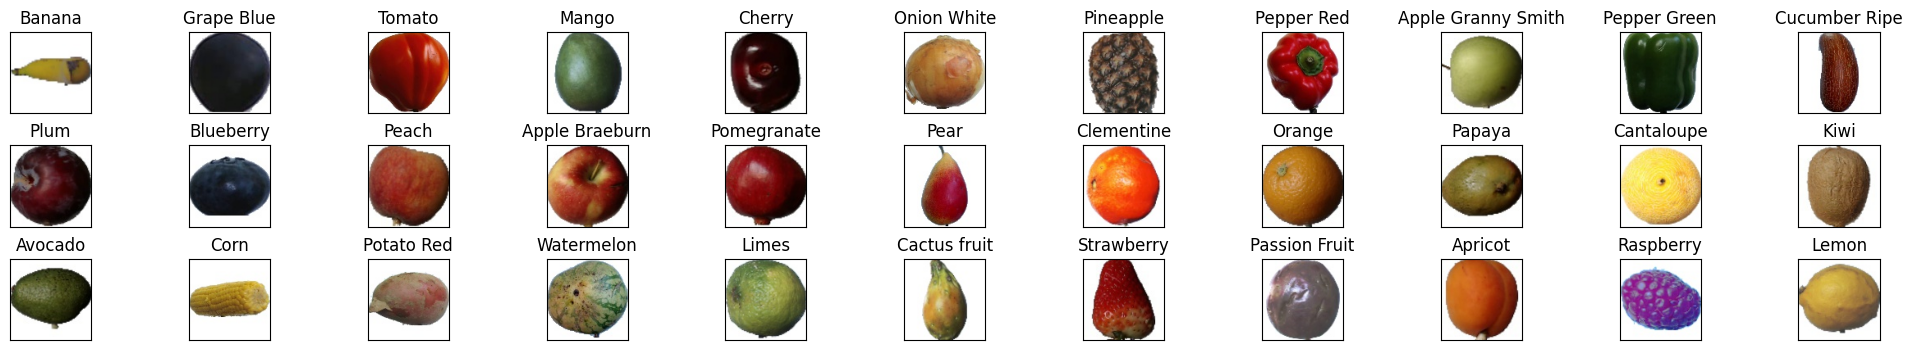

In [19]:
fig = plt.figure(figsize=(25, 4))
i = 1
for tclass in target_classes:
  ax = fig.add_subplot(3, 11, i, xticks=[], yticks=[], title = tclass)
  path = train_df[train_df['Class']==tclass]['File'][0]
  im = Image.open(path)
  plt.imshow(im)
  i += 1

fig.subplots_adjust(hspace=0.4)

Each image is 100x100 pixels with 3 channels for Red, Green, and Blue color.

In [20]:
print("The fruit and vegetable image dimensions are:", np.array(im).shape)

The fruit and vegetable image dimensions are: (100, 100, 3)


Splitting the training data into train and validation segments since the test set provided in Kaggle does not have any labels. Since there are no labels for the test data we can generate predictions but have no way of knowing whether or not they are correct.

In [92]:
X_train, X_val = train_test_split(train_df, test_size=0.3)

In [93]:
print("Model training data shape:", X_train.shape)
print("Model validation data shape:", X_val.shape)

Model training data shape: (11797, 2)
Model validation data shape: (5057, 2)


Visualizing the distrubtion of the classes across the train and validation datasets.

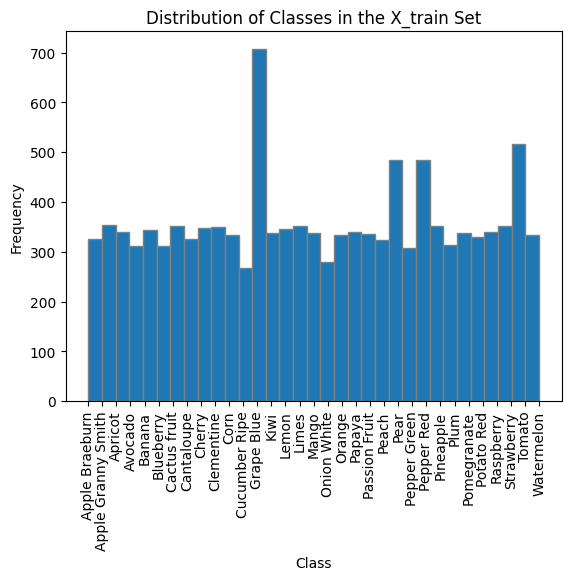

In [169]:
plt.hist(X_train['Class'].sort_values(), bins=33, edgecolor='grey')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.xticks(rotation=90)
plt.title('Distribution of Classes in the X_train Set')
plt.show()

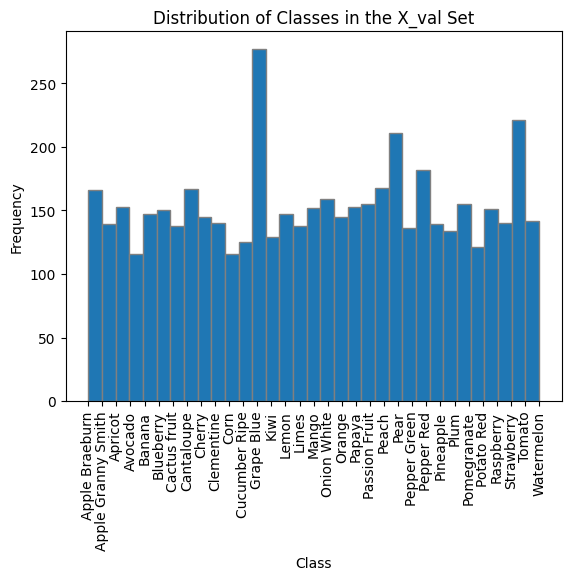

In [170]:
plt.hist(X_val['Class'].sort_values(), bins=33, edgecolor='grey')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.xticks(rotation=90)
plt.title('Distribution of Classes in the X_val Set')
plt.show()

The class distribution for both the training and validation sets appears to be quite similar. This indicates an effective train/test split.

The ImageDataGenerator() function allows for efficiency when working with images as they can take up a lot of memory. ImageDataGenerator loads images for each batch when training a neural network and the rescale argument tescales RGB values from 0-255 to 0-1.

In [113]:
datagenerator = ImageDataGenerator(rescale=1./255)

train_generator = datagenerator.flow_from_dataframe(
    dataframe=X_train,
    x_col="File",
    y_col="Class",
    target_size=(100, 100),
    color_mode="rgb",
    batch_size=32,
    class_mode="categorical",
    validate_filenames=False
)


validation_generator = datagenerator.flow_from_dataframe(
    dataframe=X_val,
    x_col="File",
    y_col="Class",
    target_size=(100, 100),
    color_mode="rgb",
    batch_size=16,
    class_mode="categorical",
    validate_filenames=False
)

test_generator = datagenerator.flow_from_dataframe(
    dataframe=test_df,
    x_col='File',
    y_col=None,
    target_size=(100, 100),
    color_mode="rgb",
    batch_size=32,
    shuffle=False,
    class_mode=None,
    validate_filenames=False
)

Found 11797 non-validated image filenames belonging to 33 classes.
Found 5057 non-validated image filenames belonging to 33 classes.
Found 5641 non-validated image filenames.


Since the dataset is composed of images there is a reduced need for many common EDA techniques that are suited for tabular data. For example computing things like the mean, median, or identifying outliers does not apply to image data. To recap we have examined the structure of the train and test data confirmed that the target class is well distributed. Furthermore, we saw an example of each of the 33 different kinds of fruits and vegetables in the dataset. Lastly, we split the data into training and validation tests to prepare for modeling.

We will now turn to modeling to help us identify features in the images that are not captured in the more traditional tabular form and help us extract meaning from the data to create a performant classifier.

### Modeling

#### Dense Model
First pass at classifying the data this time using a sequential, dense neural network as studied in earlier modeules. The network consists of a layer that flattens the input into an array and then dense, fully connected flayers of size 256, 128, and 64 with a 'relu' activation and then finally an output layer with a 'sofmax' activation function since this is multi-class classification problem.

In [129]:
dense_model = models.Sequential()
dense_model.add(layers.Flatten(input_shape=(100, 100, 3)))
dense_model.add(layers.Dense(256, activation='relu'))
dense_model.add(layers.Dense(128, activation='relu'))
dense_model.add(layers.Dense(64, activation='relu'))
dense_model.add(layers.Dense(33, activation='softmax'))

In [130]:
dense_model.summary()

Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_23 (Flatten)        (None, 30000)             0         
                                                                 
 dense_102 (Dense)           (None, 256)               7680256   
                                                                 
 dense_103 (Dense)           (None, 128)               32896     
                                                                 
 dense_104 (Dense)           (None, 64)                8256      
                                                                 
 dense_105 (Dense)           (None, 33)                2145      
                                                                 
Total params: 7723553 (29.46 MB)
Trainable params: 7723553 (29.46 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [132]:
dense_model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy', tensorflow.keras.metrics.AUC(name='auc')])

history = dense_model.fit(train_generator, epochs=10, validation_data=validation_generator)

Epoch 1/10
369/369 [==============================] - 12s 29ms/step - loss: 0.1422 - accuracy: 0.9617 - auc: 0.9965 - val_loss: 0.1398 - val_accuracy: 0.9537 - val_auc: 0.9976
Epoch 2/10
369/369 [==============================] - 11s 30ms/step - loss: 0.0615 - accuracy: 0.9819 - auc: 0.9989 - val_loss: 0.0090 - val_accuracy: 0.9968 - val_auc: 1.0000
Epoch 3/10
369/369 [==============================] - 11s 30ms/step - loss: 0.0016 - accuracy: 0.9994 - auc: 1.0000 - val_loss: 0.0026 - val_accuracy: 0.9996 - val_auc: 0.9998
Epoch 4/10
369/369 [==============================] - 11s 29ms/step - loss: 2.3093e-04 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 0.0024 - val_accuracy: 0.9996 - val_auc: 0.9999
Epoch 5/10
369/369 [==============================] - 11s 29ms/step - loss: 1.4318e-04 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 0.0028 - val_accuracy: 0.9996 - val_auc: 0.9998
Epoch 6/10
369/369 [==============================] - 11s 30ms/step - loss: 1.0332e-04 - accuracy: 1.0000 - auc:

Inititally I was quite shocked by the quality of the classifications made by this dense model. I had inititally began with a 'tanh' activation function on the dense layers and achieved mediocre success. Upon switching to a 'relu' activation which is more suited for the type of problem the model became highly accurate and quite nearly perfect.

Upon further consideration I identified several factors that help performance on this dataset.


* Dense neural networks are unable to learn the concept of proximity which often hinders them in more complex image classifications; however these images consist of a single main subject (fruit or vegetable) that have fairly consisten appearence across the image. Likewise, the images are quite small in size which lessens the prevalance of larger features like parts of a vehicle or components of a persons face.

* The images in the dataset are very consistent in color and have a wide range of distinctive colors which contributes to the ease of serpation (*compare to the cancer detection Kaggle project from earlier in the course when color gave little to no indication whether an image was postive or negative*)

* One pitfall of using Dense neural networks for image classification is the proliferation of trainable parameters; this model works very well but still requires 7.5 million parameters to be trained.

* Performance on this dataset for other Kaggle users is very high; I was unfamiliar with this dataset prior to this project and compared results to other users to gut-check these results.

* The images in the dataset are rotated to different perspectives which helps the model better learn distinctive shapes and patterns that are characteristic to a fruit/vegetable.

* Lastly, there should be no data leakage in this set since we conducted a train/test split but it would have been beneficial to score on the test data; however, this is not possible since the test images are unlabeled.



Visualizing the performance of the dense model over its training period.

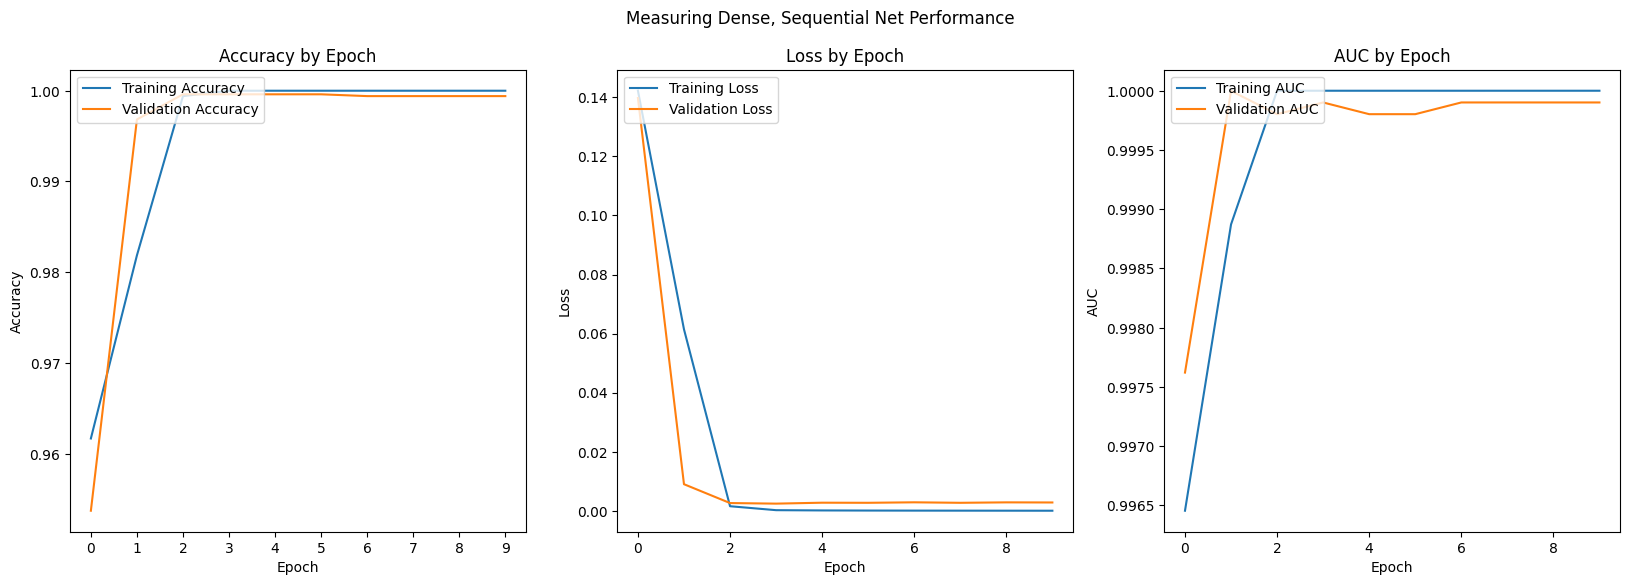

In [139]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))

# Accuracy
ax1.plot(history.history['accuracy'], label = 'Training Accuracy')
ax1.plot(history.history['val_accuracy'], label = 'Validation Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.set_xticks(np.arange(0, 10, 1))
ax1.set_title('Accuracy by Epoch')
ax1.legend(loc='upper left')

# Loss
ax2.plot(history.history['loss'], label = 'Training Loss')
ax2.plot(history.history['val_loss'], label = 'Validation Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax1.set_xticks(np.arange(0, 10, 1))
ax2.set_title('Loss by Epoch')
ax2.legend(loc='upper left')

# AUC
ax3.plot(history.history['auc'], label = 'Training AUC')
ax3.plot(history.history['val_auc'], label = 'Validation AUC')
ax3.set_xlabel('Epoch')
ax3.set_ylabel('AUC')
ax1.set_xticks(np.arange(0, 10, 1))
ax3.set_title('AUC by Epoch')
ax3.legend(loc='upper left')

fig.suptitle('Measuring Dense, Sequential Net Performance')
plt.show()

Despite lacking the stellar reputation of CNNs with image classification, the dense neural network performs excellently on the fruit and vegetable classification. The validation accuracy reaches 99.9% with the misses amounting to only 2-5 misclassifications.

#### CNN Model
Shifting to the Convolutional Neural Network (CNN) archicture since it is reputable and well-suited for image classification. This CNN follows a structure of 2D Convlutional Layers with 3x3 filters followed by a batchpooling layer, and a maxpooling layers wiht a 2x2 filter. This sequence of three layers is repeated 4 times with 96, 64, 32, and 32 filters. Lastly a convolutional layers with 16 filters processes the data before being flattened and output to a dense layer with 256 layers. The dense layers passes to an output layer with 33 nodes and a 'softmax' activation function since this is a multi-class classification.

In [134]:
cnn = models.Sequential()
cnn.add(layers.Conv2D(96, (3, 3), activation='relu', input_shape=(96, 96, 3)))
cnn.add(layers.BatchNormalization())
cnn.add(layers.MaxPooling2D((2, 2)))
cnn.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(96, 96, 3)))
cnn.add(layers.BatchNormalization())
cnn.add(layers.MaxPooling2D((2, 2)))
cnn.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(96, 96, 3)))
cnn.add(layers.BatchNormalization())
cnn.add(layers.MaxPooling2D((2, 2)))
cnn.add(layers.Conv2D(32, (3, 3), activation='relu'))
cnn.add(layers.BatchNormalization())
cnn.add(layers.MaxPooling2D((2, 2)))
cnn.add(layers.Conv2D(16, (3, 3), activation='relu'))
cnn.add(layers.Flatten())
cnn.add(layers.Dense(256, activation='relu'))
cnn.add(layers.Dense(33, activation='softmax'))

In [135]:
cnn.summary()

Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_11 (Conv2D)          (None, 94, 94, 96)        2688      
                                                                 
 batch_normalization_4 (Bat  (None, 94, 94, 96)        384       
 chNormalization)                                                
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 47, 47, 96)        0         
 g2D)                                                            
                                                                 
 conv2d_12 (Conv2D)          (None, 45, 45, 64)        55360     
                                                                 
 batch_normalization_5 (Bat  (None, 45, 45, 64)        256       
 chNormalization)                                                
                                                     

Note that despite providing even better performance than the dense model the CNN model only uses ~117,000 parameters compared to the ~7,500,000 parameters used in the dense model.

In [149]:
cnn.compile(optimizer='nadam',
              loss='categorical_crossentropy',
              metrics=['accuracy', tensorflow.keras.metrics.AUC(name='auc')])

history_cnn = cnn.fit(train_generator, epochs=5, validation_data=validation_generator)

Epoch 1/5
369/369 [==============================] - 16s 29ms/step - loss: 0.0099 - accuracy: 0.9983 - auc: 0.9996 - val_loss: 0.0017 - val_accuracy: 0.9992 - val_auc: 1.0000
Epoch 2/5
369/369 [==============================] - 11s 29ms/step - loss: 0.0038 - accuracy: 0.9995 - auc: 0.9999 - val_loss: 0.0010 - val_accuracy: 0.9998 - val_auc: 1.0000
Epoch 3/5
369/369 [==============================] - 11s 29ms/step - loss: 1.1384e-05 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 8.7731e-06 - val_accuracy: 1.0000 - val_auc: 1.0000
Epoch 4/5
369/369 [==============================] - 11s 29ms/step - loss: 3.8639e-06 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 9.0730e-06 - val_accuracy: 1.0000 - val_auc: 1.0000
Epoch 5/5
369/369 [==============================] - 10s 28ms/step - loss: 0.0163 - accuracy: 0.9972 - auc: 0.9994 - val_loss: 0.0055 - val_accuracy: 0.9986 - val_auc: 0.9998


Visualizing the performance of the CNN model over its training period.

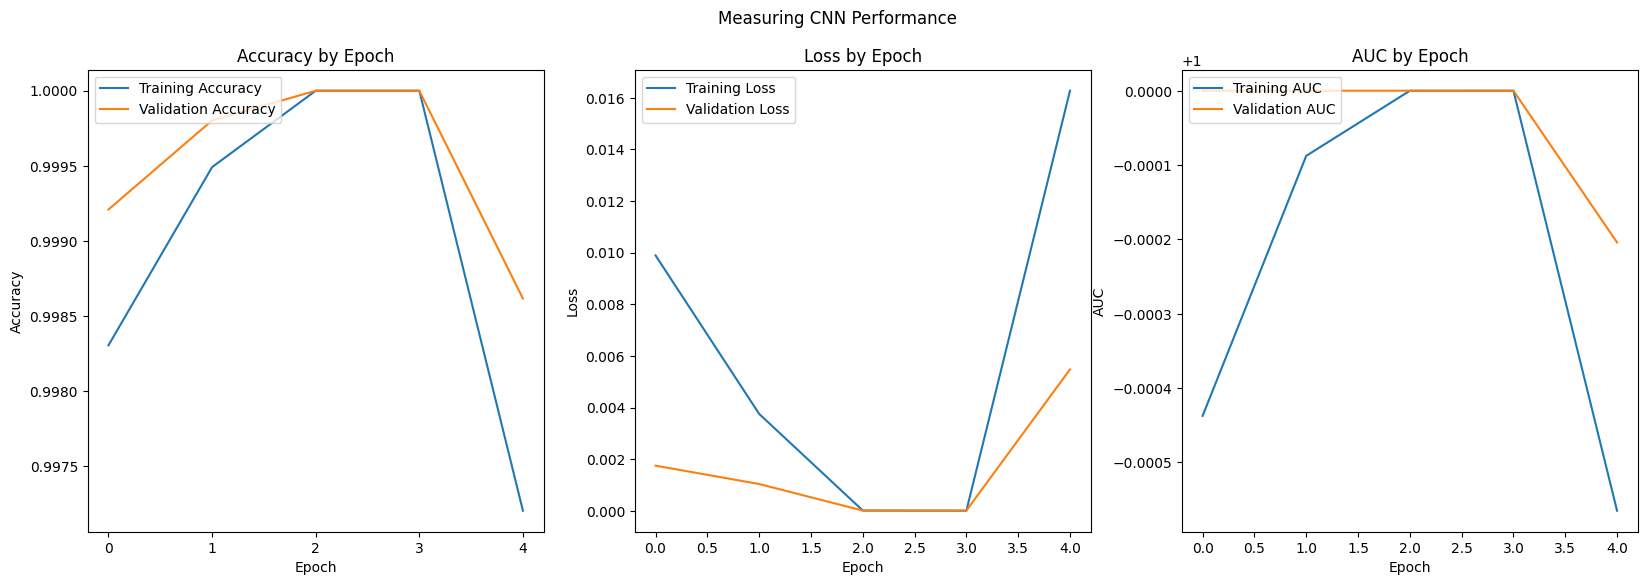

In [151]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))

# Accuracy
ax1.plot(history_cnn.history['accuracy'], label = 'Training Accuracy')
ax1.plot(history_cnn.history['val_accuracy'], label = 'Validation Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.set_xticks(np.arange(0, 5, 1))
ax1.set_title('Accuracy by Epoch')
ax1.legend(loc='upper left')

# Loss
ax2.plot(history_cnn.history['loss'], label = 'Training Loss')
ax2.plot(history_cnn.history['val_loss'], label = 'Validation Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax1.set_xticks(np.arange(0, 5, 1))
ax2.set_title('Loss by Epoch')
ax2.legend(loc='upper left')

# AUC
ax3.plot(history_cnn.history['auc'], label = 'Training AUC')
ax3.plot(history_cnn.history['val_auc'], label = 'Validation AUC')
ax3.set_xlabel('Epoch')
ax3.set_ylabel('AUC')
ax1.set_xticks(np.arange(0, 5, 1))
ax3.set_title('AUC by Epoch')
ax3.legend(loc='upper left')

fig.suptitle('Measuring CNN Performance')
plt.show()

The CNN aces the test on the fruit and vegetable classification; after the third and fourth epoch the model achieves 100% accuracy as it has properly classified all images in the validation set to their proper fruit or vegetable type. We can notice that the accuracy marginally decreases on the fifth epoch and this is due to the model over-reacting to such a small loss and thus over-correcting on a few classifications.


Several of the factors that contributed to the strong performance of the dense network also apply to the CNN model as well as some unique facots:

* CNNs due to their structure and reduction of image dimensions from layer to label are able to learn the concept of proximity which is helpful for image classifaction (particularly more complex images).

* The images in this dataset consist of a single main subject (fruit or vegetable) that have fairly consisten appearence across the image. Likewise, the images are quite small in size which also lends to better classification.

* The images in the dataset are very consistent in color and have a wide range of distinctive colors which contributes to the ease of serpation (*compare to the cancer detection Kaggle project from earlier in the course when color gave little to no indication whether an image was postive or negative*)

* One benefit of the CNN as opposed to the Dense neural network for image classification is the reduction of trainable parameters as the number of parameters is reduced from 7.5 million to just over 100 thousand; this is over a fifty-fold decrease and will help the CNN scale well.

* Performance on this dataset for other Kaggle users is very high; I was unfamiliar with this dataset prior to this project and compared results to other users to gut-check these results.

* The images in the dataset are rotated to different perspectives which helps the model better learn distinctive shapes and patterns that are characteristic to a fruit/vegetable.

* Lastly, there should be no data leakage in this set since we conducted a train/test split but it would have been beneficial to score on the test data; however, this is not possible since the test images are unlabeled.

## **Conclusions**

We achieved our goal by creating two highly performant classifers for the fruit and vegetable images we used. The first is a Sequential Neural Network with Dense layers that performed great achieving a 99.9% accuracy on the validation set. The second is a Convolution Neural Network (CNN) that was able to learn the data and achieved perfect (100%) accuracy on a validation set of over 5,000 images.

The biggest thing I learnd from this project are some of the features that lend to highly performant image classification. These include smaller images with a large main subject, distinctive and consistent colors associated with classes, rotation of images to help the model learn the shapes characteristic to a class.Before beginning this project, I thought this dataset would be difficult to peform well with but soon learned that this data led to an approachable path to an excellent (even perefect) classifier.

Most things I tried for this project worked but the one thing that did not was when I tried using the 'tanh' activation function in the dense layers as opposed to the more apt 'relu' function. RELU is quicker and more resistant to the vanishing gradient problem than 'tanh'; though 'tanh' was still increasing in accuracy after 10 epochs it paled in comaprison to RELU which yieleded accuracy over 90% after 2-4 epochs.

One way to improve this project would be to have labels on the test set provided by Kaggle. Since the train/test split was conducted properly there is no data leakage but it would have been re-affirming to evaluate the model on a true test set. Furthermore, as far as the final project goes I would like to try multi-class classification with images on a more challenging dataset as this dataset yielded to quick and highly effective results the need for extensive hyperparameter tuning and model architecting was diminished.